## MO444 Project 2 - Supervised Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

The goal of this project was to solve a regression and a classification task. In the regression task, the main objective was to predict the trajectory of a ball kicked by a robot, and based on that prediction, determine whether the goalkeeper robot will defend the kick or not. In the classification task, given handwritten digits (from 0 to 9), the objective is to classify them correctly.

Two datasets were used, [Pen-Based Recognition of Handwritten Digits Data Set
](archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) for the classification task, which is a dataset with 8x8 images and it's respective classes, and [kick1.dat](./data/kick1.dat), [kick2.dat](./data/kick2.dat) for the regression tasks, which has coordinates x, y and z of the trajectory of the ball in 20 frames (with 1 second interval).

### Contributions:
* Rodrigo
 * Part I - Regression Task
 * Part II - Classification Task
* Felipe
 * Part I - Regression Task

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()

# PART I - Regression Task

In this part of the project, the objective was to predict the trajectory of a ball kicked by a robot, and based on that prediction, determine whether the goalkeeper robot will defend the kick or not.

## Loading dataset

We start by loading data from the trajectory of the kicks, and plotting them to see what they looks like

In [2]:
kick1 = np.genfromtxt(os.path.join("data", "kick1.dat"), delimiter=' ')
kick2 = np.genfromtxt(os.path.join("data", "kick2.dat"), delimiter=' ')

In [3]:
def plot_data(data, prediction=None):
    x, y, z = data[:, 0], data[:, 1], data[:, 2]

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection="3d")
    ax.set_xlabel("x axis")
    ax.set_ylabel("y axis")
    ax.set_zlabel("z axis")
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 2.1)
    ax.set_zlim(0, 0.5)

    x_field = np.linspace(-3, 3, 2)
    y_field = np.linspace(0, 2.1, 2)
    x_field, y_field = np.meshgrid(x_field, y_field)
    z_field = np.zeros(x_field.shape)
    ax.plot_surface(x_field, y_field, z_field, shade=False, color='g', alpha=.4)

    ax.plot([-2.5, -2.5], [0, 1.25], zdir='z', c='g')
    ax.plot([-2.5, 2.5], [1.25, 1.25], zdir='z', c='g')
    ax.plot([2.5, 2.5], [0, 1.25], zdir='z', c='g')
    
    ax.plot([-2.5, -2.5], [0, 0.3], zdir='y', c='b')
    ax.plot([-2.5, 2.5], [0.3, 0.3], zdir='y', c='b')
    ax.plot([2.5, 2.5], [0, 0.3], zdir='y', c='b')

    ax.scatter3D(x, y, z, c='b')
    if prediction is not None:
        x, y, z = prediction[:, 0], prediction[:, 1], prediction[:, 2]
        ax.scatter3D(x, y, z, c='r')

    ax.view_init(15, 10)

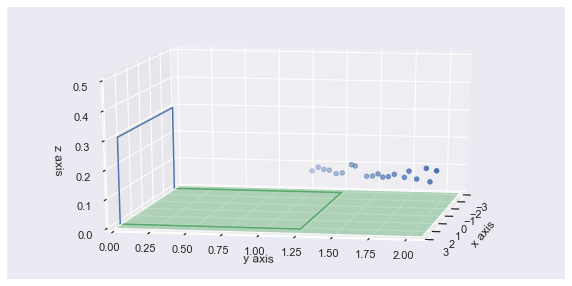

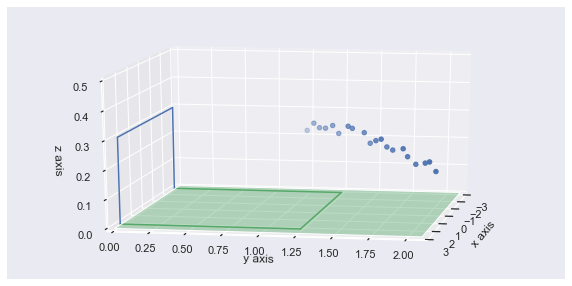

In [4]:
plot_data(kick1)
plot_data(kick2)

In this project, we defined that our goalkeeper will defend the kick if the ball hits the area denoted by the blue lines, in the Z axis. This area has a height of 0.3 in the Z axis, and 5 of width in the x axis (starting from -2.5 up to 2.5).

By intuition, both kicks are going in the direction of the goal and should score a goal, but since they should hit the blue area, the goalpeaker should defend.

## Linear regression implementation

Below it's implemented Linear regression and Polynomial regression in the same class. Our implementation expects the user to define the following parameters:
* **epochs**: Number of epochs to train the algorithm
* **learning rate**: Parameter used by the gradient descent to control how much to change the model in response to the estimated error
* **batch size**: Size of the mini batch, number of examples to taken into account to update the parameters of the line/polynomial.
* **loss function**: Metric used to calculate how far the line/polynomial defined by the algorithm is from the data.
* **order**: The order of the polynomial used to define a line/polynomial by the algorithm.

In [5]:
class LinearRegression:
    def __init__(self, epochs=10, learning_rate=1e-4,
                 batch_size=16, loss_function='rmse',
                 order=1):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loss_function = loss_function
        self.order = order
        self._fit = False


    def _get_loss(self, y_true, y_pred):
        assert y_true.shape[0] == y_pred.shape[0]

        errors = np.zeros(y_true.shape[0])

        for i, (y_true_, y_pred_) in enumerate(zip(y_true, y_pred)):
            if self.loss_function == 'mse':
                errors[i] = mean_squared_error(y_true_, y_pred_)
            elif self.loss_function == 'rmse':
                errors[i] = mean_squared_error(y_true_, y_pred_, squared=False)
            elif self.loss_function == "mae":
                errors[i] = mean_absolute_error(y_true_, y_pred_)
            else:
                raise Exception("Loss function not defined")
        
        return (np.sum(errors))/y_true.shape[0]


    def _get_batches(self, X, y):
        def _generate_mini_batch(data):
            num_batches = data.shape[0]//self.batch_size
            if data.shape[0] % self.batch_size != 0:
                num_batches += 1
            batches = []
            for i in range(num_batches):
                batches.append(data[i*self.batch_size:(i*self.batch_size)+self.batch_size])
            batches = np.array(batches, dtype='object')
            return batches

        batches_x = _generate_mini_batch(X)
        batches_y = _generate_mini_batch(y)

        return batches_x, batches_y


    def _evaluate_gradient(self, batch_x, batch_y, verbose=False):
        predictions = self.predict(batch_x)
        loss_batch = self._get_loss(batch_y, predictions)
        params_grad = np.zeros(self.n_params)

        for i in range(self.n_params):
            if i == self.n_params - 1:
                params_grad[i] = np.sum(predictions - batch_y)/batch_x.shape[0]
            else:
                # For order 1 -> batch_x_pos = 0, 0...
                # For order 2 -> batch_x_pos = 0, 1, 0, 1...
                # For order 3 -> batch_x_pos = 0, 1, 2, 0, 1, 2...
                batch_x_pos = i % batch_x.shape[1]
                params_grad[i] = (np.sum((predictions - batch_y) * batch_x[:, batch_x_pos].reshape(-1, 1) ** self.coeff))/batch_x.shape[0]
                
        return params_grad, loss_batch


    def fit(self, X, y, verbose=False, print_every=10):
        assert X.shape[0] == y.shape[0]
        if X.shape[0] < self.batch_size:
            raise Exception("Batch size is greater than data size, please reduce it's size")
        self._fit = True

        np.random.seed(42)

        self.n_params = X.shape[1] * self.order + 1
        self.coeff = np.tile(np.arange(self.order, 0, -1), X.shape[1])
        self.params = np.random.rand(self.n_params)

        loss = []
        for epoch in range(self.epochs):
            if verbose and ((epoch + 1) % print_every == 0 or epoch == 0):
                print("Epoch {}/{}: ".format(epoch + 1, self.epochs), end="")
            #np.random.shuffle(X)
            loss_epoch = 0
            batches_x, batches_y = self._get_batches(X, y)
            for batch_x, batch_y in zip(batches_x, batches_y):
                params_grad, loss_batch = self._evaluate_gradient(batch_x, batch_y, verbose)
                self.params = self.params - self.learning_rate * params_grad
                loss_epoch += loss_batch
            if verbose and ((epoch + 1) % print_every == 0 or epoch == 0):
                print("Loss: {:.4f}".format(loss_epoch/batches_x.shape[0]))
                
            loss.append(loss_epoch/batches_x.shape[0])

        return loss


    def predict(self, X):
        if not self._fit:
            raise Exception("fit must be executed before predict")
        predictions = np.empty(X.shape[0])

        for i, x in enumerate(X):
            x = np.tile(x, self.order)
            predictions[i] = np.sum(self.params[:-1] * x ** self.coeff) + self.params[-1]

        return predictions.reshape(-1, 1)

## Defining a function to fit the data to the regressor and check the quality of the fitting

Here we define a function to train a regressor and also check the quality of the regression. The quality of the regression is checked by using as input the data from the first 20 frames, and checking how close the points predicted is from the original. 

In this project, we choose to provide y coordinates to the regressor, and predict x and z coordinates using two different regressors, one for x axis (y -> x) and another for z ais (y -> z). This approach was chosen to take advantage of the fact that the ball is going towards the goal, that is, moving in the -y direction, so we can estimate y for the next 40 frames.

In [6]:
def fit_data(X, y, e, lr, bs, o, lf, axis="X"):
    lr = LinearRegression(epochs=e,
                            learning_rate=lr,
                            batch_size=bs,
                            order=o,
                            loss_function=lf)
    loss = lr.fit(X, y, verbose=False)

    plt.title("Loss during training - Linear Regressor for {} axis".format(axis))
    plt.plot(np.arange(1, epochs + 1), loss)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    pred = lr.predict(X)

    plt.title("Checking quality of the prediction for {} axis".format(axis))
    plt.plot(X, y, label="Ground truth")
    plt.plot(X, pred, label="Prediction")
    plt.legend()
    plt.ylabel("{} axis".format(axis))
    plt.xlabel("Y axis")
    plt.show()
    
    return lr

## Training linear/polynomiar regressor for kick1 and kick2

In the next cells, it's trained regressors to predict the trajectory of kick1 and kick2 using a linear and a polynomial regressor. Through experimentation, it was observed that a polynomial of order 1 to describe kick 1, and a polynomial of order 2 to describe kick2, are the best configurations for regressors to predict trajectories.

## Kick 1 - Linear

Training a regressor using data from Kick1 considering a polynomial of order 1.

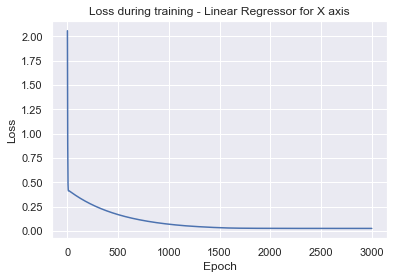

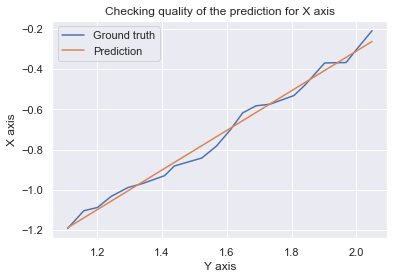

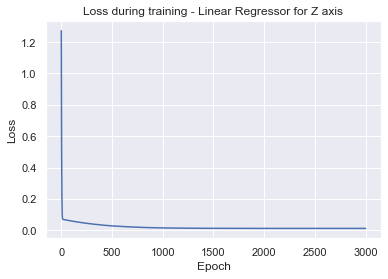

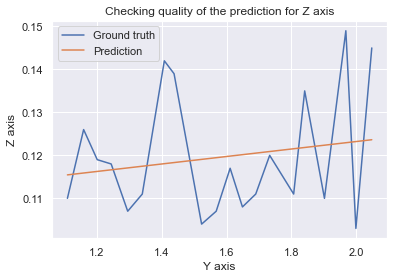

In [7]:
kick = kick1

kick_x = kick[:, 0].reshape(-1, 1)
kick_y = kick[:, 1].reshape(-1, 1)
kick_z = kick[:, 2].reshape(-1, 1)

start_value = kick_y[-1] - (kick_y[-2] - kick_y[-1])
kick_y_next_frames = np.linspace(start_value, 0, 40)

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 1
loss_function = "rmse"

lr_x = fit_data(kick_y, kick_x, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="X")

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 1
loss_function = "rmse"

lr_z = fit_data(kick_y, kick_z, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="Z")

As can be seen in the plots, the regressors showed a low error during training, and the predicted lines were close to the data, as far as possible, since the Z axis data is very noisy.

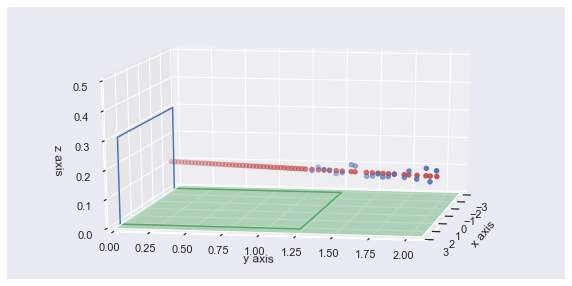

In [8]:
pred_x = lr_x.predict(kick_y)
pred_y = kick_y
pred_z = lr_z.predict(kick_y)

xyz_pred = np.concatenate((pred_x, pred_y, pred_z), axis=1)

pred_x_next_frames = lr_x.predict(kick_y_next_frames)
pred_y_next_frames = kick_y_next_frames
pred_z_next_frames = lr_z.predict(kick_y_next_frames)

pred_x_next_frames = np.concatenate((pred_x_next_frames,
                                     pred_y_next_frames,
                                     pred_z_next_frames), axis=1)

pred_full = np.concatenate((xyz_pred, pred_x_next_frames), axis=0)

plot_data(kick1, pred_full)

As can be seen in the plots, the ball it's going in the direction of the goal, but it should hit the blue area, so **the goalkeeper will defend the kick**.

## Kick 1 - Polynomial (order 2)

Training a regressor using data from Kick1 considering a polynomial of order 2. He we choose order 2, because it was the best fit for the data, when trying to increase the order of the polynomial, like for 5 or 7 for example, we observed a very high error, in relation to polynomials with lower orders, and the line was very far from the data.

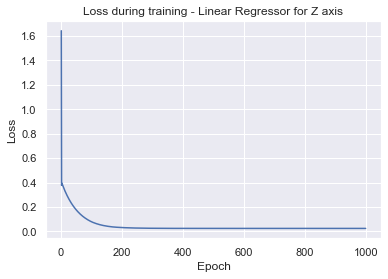

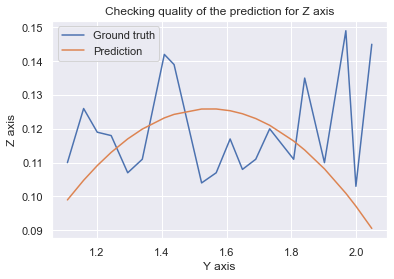

In [9]:
kick = kick1

kick_x = kick[:, 0].reshape(-1, 1)
kick_y = kick[:, 1].reshape(-1, 1)
kick_z = kick[:, 2].reshape(-1, 1)

start_value = kick_y[-1] - (kick_y[-2] - kick_y[-1])
kick_y_next_frames = np.linspace(start_value, 0, 40)

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 2
loss_function = "rmse"

#lr_x = fit_data(kick_y, kick_x, epochs,
#         learning_rate, batch_size,
#         order, loss_function, axis="X")

epochs = 1000
learning_rate = 5e-2
batch_size = 5
order = 2
loss_function = "rmse"

lr_z = fit_data(kick_y, kick_z, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="Z")

As can be seen in the plots, the regressors showed a low error, the polynomial of the x axis was very close to the data, however, the polynomial representing the z axis, did not have a very good fit, this probably occurred because the z axis has a very large variance with respect to the y-axis.

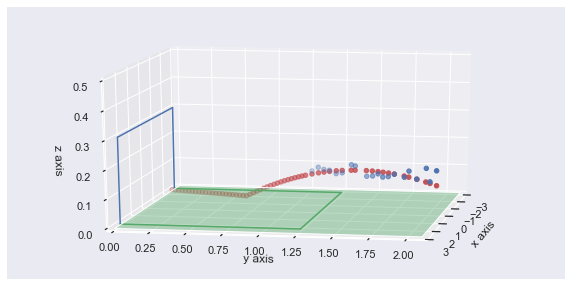

In [10]:
pred_x = lr_x.predict(kick_y)
pred_y = kick_y
pred_z = lr_z.predict(kick_y)
pred_z = np.where(pred_z < 0, 0, pred_z)

xyz_pred = np.concatenate((pred_x, pred_y, pred_z), axis=1)

pred_x_next_frames = lr_x.predict(kick_y_next_frames)
pred_y_next_frames = kick_y_next_frames
pred_z_next_frames = lr_z.predict(kick_y_next_frames)
pred_z_next_frames = np.where(pred_z_next_frames < 0, 0, pred_z_next_frames)

pred_x_next_frames = np.concatenate((pred_x_next_frames,
                                     pred_y_next_frames,
                                     pred_z_next_frames), axis=1)

pred_full = np.concatenate((xyz_pred, pred_x_next_frames), axis=0)

plot_data(kick1, pred_full)

As can be seen in the plots, the ball it's going in the direction of the goal, but it should hit the blue area, so **the goalkeeper will defend the kick**. Since a negative value on the z-axis is not actually possible (the ball would be below the field), values of z less than zero were converted to 0, simulating the effect of the ball hitting the ground and staying there.

## Kick 2 - Linear

Training a regressor using data from Kick2 considering a polynomial of order 1.

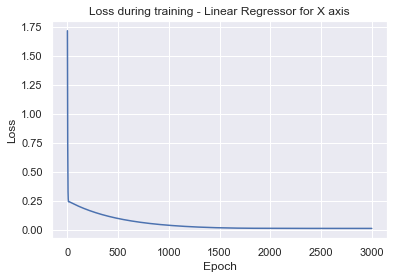

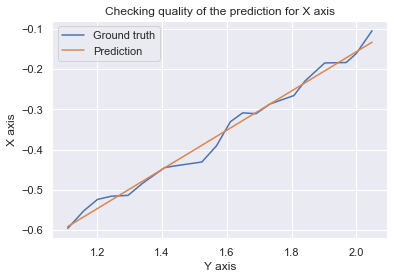

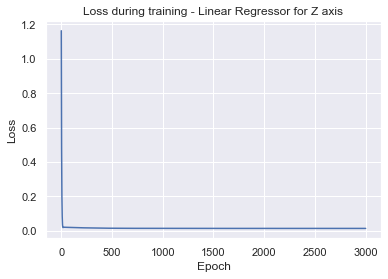

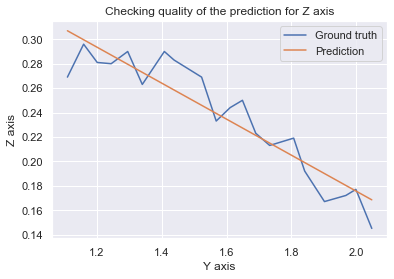

In [11]:
kick = kick2

kick_x = kick[:, 0].reshape(-1, 1)
kick_y = kick[:, 1].reshape(-1, 1)
kick_z = kick[:, 2].reshape(-1, 1)

start_value = kick_y[-1] - (kick_y[-2] - kick_y[-1])
kick_y_next_frames = np.linspace(start_value, 0, 40)

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 1
loss_function = "rmse"

lr_x = fit_data(kick_y, kick_x, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="X")

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 1
loss_function = "rmse"

lr_z = fit_data(kick_y, kick_z, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="Z")

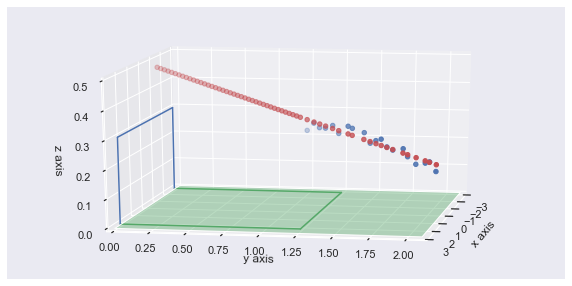

In [12]:
pred_x = lr_x.predict(kick_y)
pred_y = kick_y
pred_z = lr_z.predict(kick_y)

xyz_pred = np.concatenate((pred_x, pred_y, pred_z), axis=1)

pred_x_next_frames = lr_x.predict(kick_y_next_frames)
pred_y_next_frames = kick_y_next_frames
pred_z_next_frames = lr_z.predict(kick_y_next_frames)

pred_x_next_frames = np.concatenate((pred_x_next_frames,
                                     pred_y_next_frames,
                                     pred_z_next_frames), axis=1)

pred_full = np.concatenate((xyz_pred, pred_x_next_frames), axis=0)

plot_data(kick2, pred_full)

As can be seen in the plots, the ball is going completely out of the direction of the goal, so the goalkeeper does not have to defend.

## Kick 2 - Polynomial (order 2)

Training a regressor using data from Kick2 considering a polynomial of order 2. Here we choosed order 2, because like what happened with kick1, it was the best fit for the data, when trying to increase the order of the polynomial, like for 5 or 7 for example, a behavior similar to the degree 2 polynomial was observed, however, the data did not fit so well to the polynomials, presenting a greater error.

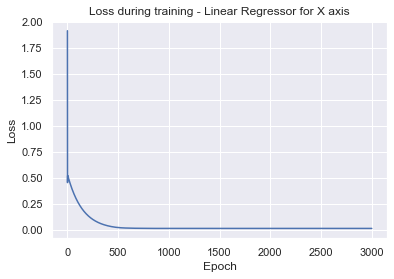

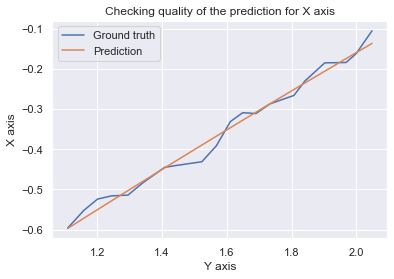

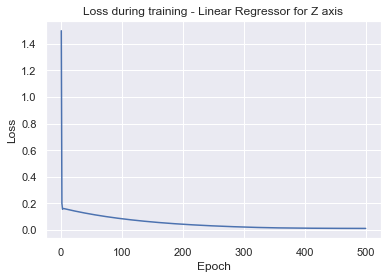

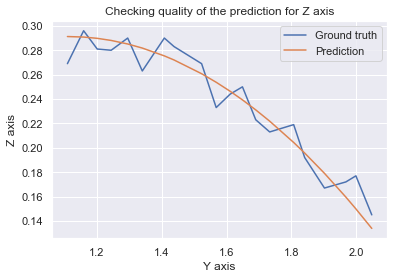

In [13]:
kick = kick2

kick_x = kick[:, 0].reshape(-1, 1)
kick_y = kick[:, 1].reshape(-1, 1)
kick_z = kick[:, 2].reshape(-1, 1)

start_value = kick_y[-1] - (kick_y[-2] - kick_y[-1])
kick_y_next_frames = np.linspace(start_value, 0, 40)

epochs = 3000
learning_rate = 2e-2
batch_size = 5
order = 2
loss_function = "rmse"

lr_x = fit_data(kick_y, kick_x, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="X")

epochs = 500
learning_rate = 2e-2
batch_size = 5
order = 2
loss_function = "rmse"

lr_z = fit_data(kick_y, kick_z, epochs,
         learning_rate, batch_size,
         order, loss_function, axis="Z")

As can be seen in the plots, the regressors showed a low error during training, and the predicted lines were very close to the data.

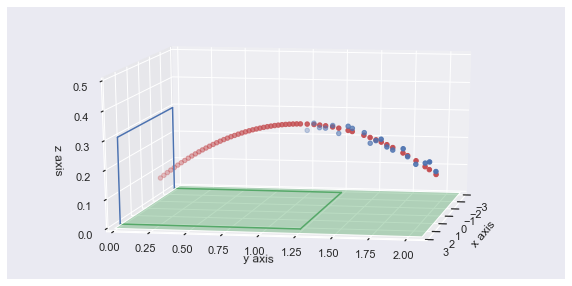

In [14]:
pred_x = lr_x.predict(kick_y)
pred_y = kick_y
pred_z = lr_z.predict(kick_y)

xyz_pred = np.concatenate((pred_x, pred_y, pred_z), axis=1)

pred_x_next_frames = lr_x.predict(kick_y_next_frames)
pred_y_next_frames = kick_y_next_frames
pred_z_next_frames = lr_z.predict(kick_y_next_frames)

pred_x_next_frames = np.concatenate((pred_x_next_frames,
                                     pred_y_next_frames,
                                     pred_z_next_frames), axis=1)

pred_full = np.concatenate((xyz_pred, pred_x_next_frames), axis=0)

plot_data(kick2, pred_full)

As can be seen in the plots, the ball it's going in the direction of the goal, but it should hit the blue area, so **the goalkeeper will defend the kick**.

# PART II - Classification Task

In this part of the project, the objective is to solve a classification task using supervised learning methods. The task is to classify handwrite digits from 0 to 9, using the 64 features (8x8 images) given by Optical Recognition of Handwritten Digits dataset.

In [15]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from scipy import stats

## Loading dataset and spliting data

Loading the dataset using sklearn function `load_digits`, and splitting data into training/test set, with 90% and 10% of the total data respectively. 

In [16]:
X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42)

## Data preprocessing

Applying a normalization to the input data, so that the range of features is in the interval of [0, 1]. This kind of normalization is usefull to help the algorithms converge to a solution faster, and also improves the numerical stability of the models.

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Checking training set features

In [18]:
for feature in range(X_train.shape[1]):
    print("Feature {}:".format(feature + 1))
    print(stats.describe(X_train[:, feature]))
    print()

Feature 1:
DescribeResult(nobs=1617, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)

Feature 2:
DescribeResult(nobs=1617, minmax=(0.0, 1.0), mean=0.03811069882498454, variance=0.012711666574820748, skewness=3.9838956005747304, kurtosis=19.170683010328545)

Feature 3:
DescribeResult(nobs=1617, minmax=(0.0, 1.0), mean=0.32537105751391465, variance=0.08898423723112109, skewness=0.5953575265339885, kurtosis=-0.8261381853784053)

Feature 4:
DescribeResult(nobs=1617, minmax=(0.0, 1.0), mean=0.7402597402597403, variance=0.0704592920229523, skewness=-1.2445055029407237, kurtosis=0.8328337842045235)

Feature 5:
DescribeResult(nobs=1617, minmax=(0.0, 1.0), mean=0.742617501546073, variance=0.07146899917989247, skewness=-1.1487256657050255, kurtosis=0.4833052005264724)

Feature 6:
DescribeResult(nobs=1617, minmax=(0.0, 1.0), mean=0.3633658008658009, variance=0.12510386780865587, skewness=0.539763749856206, kurtosis=-1.1789146056469137)

Feature 7:
DescribeResult(nobs=1617,

### Checking test set features

In [19]:
for feature in range(X_test.shape[1]):
    print("Feature {}:".format(feature + 1))
    print(stats.describe(X_test[:, feature]))
    print()

Feature 1:
DescribeResult(nobs=180, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)

Feature 2:
DescribeResult(nobs=180, minmax=(0.0, 0.875), mean=0.03680555555555556, variance=0.014262783209186843, skewness=4.124439285125851, kurtosis=19.14410910707615)

Feature 3:
DescribeResult(nobs=180, minmax=(0.0, 1.0), mean=0.3246527777777778, variance=0.08275563993637493, skewness=0.5970095005272487, kurtosis=-0.6643239560342473)

Feature 4:
DescribeResult(nobs=180, minmax=(0.0, 1.0), mean=0.7350694444444444, variance=0.0714195133069522, skewness=-1.2360545748163756, kurtosis=0.8336038808319728)

Feature 5:
DescribeResult(nobs=180, minmax=(0.0, 1.0), mean=0.7215277777777778, variance=0.07482202436374921, skewness=-1.0147806775498316, kurtosis=0.16358392557445312)

Feature 6:
DescribeResult(nobs=180, minmax=(0.0, 1.0), mean=0.3434027777777778, variance=0.12864425725481068, skewness=0.5991587789075642, kurtosis=-1.11833280459927)

Feature 7:
DescribeResult(nobs=180, minmax

All features have been successfully normalized. Observing the descriptive statistics of each one, it is possible to notice that not all of them will be useful for the algorithms learn, as is the case of feature 1, which has a value of 0 in all images from the training and test set.

## Plotting data using t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a unsupervised technique developed in 2008, which is mainly used for data exploration and visualizing high-dimensional data. Here it is used to recude the dimensionaly of the input data to 2, so we can plot then in a 2d space, and have a intuition of how the data is arranged in the high-dimensional space.

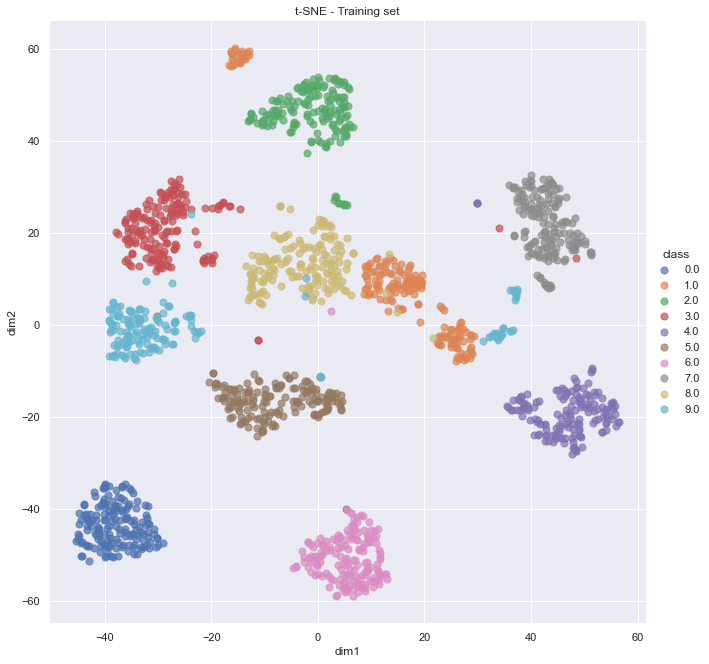

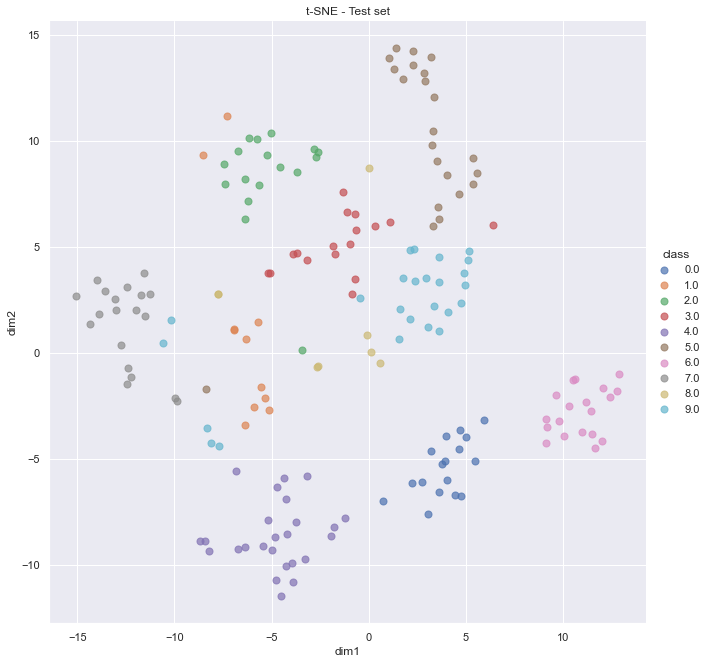

In [20]:
def plot_data_using_tsne(X, y, split="Training set"):
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)
    X_embedded_df = pd.DataFrame(np.concatenate((X_embedded, y.reshape(-1, 1)), axis=1),
                                 columns=["dim1", "dim2", "class"])

    sns.lmplot(x="dim1",
               y="dim2",
               data=X_embedded_df,
               hue="class",
               height=9,
               fit_reg=False,
               legend=True,
               scatter_kws={'s': 50, 'alpha': 0.7})
    plt.title("t-SNE - {}".format(split))
    plt.show()

plot_data_using_tsne(X_train, y_train, split="Training set")
#plot_data_using_tsne(X_valid, y_valid, split="Validation set")
plot_data_using_tsne(X_test, y_test, split="Test set")

As we can see in the plots, in general, it is possible to distinguish the digits well using the given features, but there are some digits, like 9 and 1, that are not well separated from the others, and therefore, we can expect a lower recall in their classification. This behavior can be observed in both training and test set.

## Checking data distribution

Checking if the dataset is balanced or not, in order to choose the appropriate metrics to evaluate the algorithms

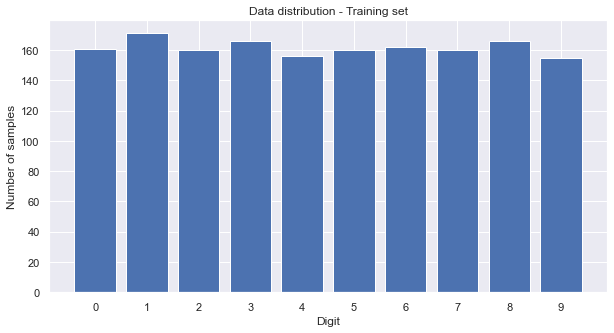

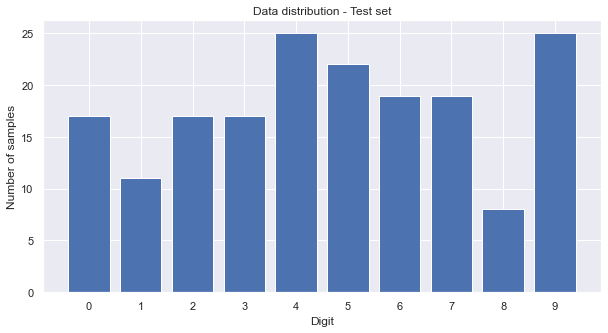

In [21]:
def plot_data_distribution(y, split="Training"):
    classes, count = np.unique(y, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.title("Data distribution - {} set".format(split))
    plt.bar(classes, count)
    plt.xticks(classes)
    plt.xlabel('Digit')
    plt.ylabel('Number of samples')
    plt.show()
    
plot_data_distribution(y_train, split="Training")
#plot_data_distribution(y_valid, split="Validation")
plot_data_distribution(y_test, split="Test")

Through the plots above, it is possible to observe that the training sets is balanced. The test set shows a certain imbalance, due to the lack of examples of class 8 and 1, but if taking into account the absolute number of images, this is not a huge imbalance, since the test set has only a few images.

## Training Supervised learning algorithms using cross validation

It was chosen to use a Neural Network (MLP) and a Random Forest, to solve the classification task proposed in this project. These choices were made due to their excellent ability generalize, and because they are able to deal well with outliers, which are present in the dataset used.

In this first part of the training process, we train the algorithms using hyperparameters choosen before a parameter tuning. To evaluate them, were used a 10-fold cross-validation technique, taking into account the recall of the MLP and Random forest in the validation set.

Recall was chosen in this problem, because we are interested in the proportion of digits of a class that were classified correctly (TP), among the total amount of digits of that same class, that were classified correctly or not (TP + FN), that is, was measured the sensitivity of the algorithms.

In [22]:
def get_index_best_model(metrics):
    m = max(metrics)
    best_index = [i for i, j in enumerate(metrics) if j == m][0]
    
    return best_index

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 100, 50),
                    learning_rate_init=1e-3,
                    solver='sgd',
                    batch_size=256,
                    max_iter=500,
                    tol=1e-3,
                    validation_fraction=0,
                    verbose=False,
                    random_state=42)

rf = RandomForestClassifier(n_estimators=10,
                            max_depth=3,
                            min_samples_split=10,
                            random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=27)

metrics = []
models = []
for fold, (train_index, validation_index) in enumerate(kfold.split(X_train)):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[validation_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[validation_index]

    mlp_, rf_ = clone(mlp), clone(rf)
    
    mlp_ = mlp_.fit(X_train_cv, y_train_cv)
    rf_ = rf_.fit(X_train_cv, y_train_cv)
    
    models.append([mlp_, rf_])

    pred_valid_mlp = mlp_.predict(X_valid_cv)
    pred_valid_rf = rf_.predict(X_valid_cv)
    
    recall_mlp = recall_score(y_valid_cv, pred_valid_mlp, average='micro')
    recall_rf = recall_score(y_valid_cv, pred_valid_rf, average='micro')
    
    print("Fold {} -> MLP recall: {:.4f} Random Forest recall: {:.4f}".format(fold + 1,
                                                                             recall_mlp,
                                                                             recall_rf))
    
    metrics.append([recall_mlp, recall_rf])

print()

metrics = np.array(metrics)
average_recall = np.mean(metrics, axis=0)

print("Average Recall:")
print("-> MLP          : {:.4f}".format(average_recall[0]))
print("-> Random Forest: {:.4f}".format(average_recall[1]))

print()

best_fold_mlp = get_index_best_model(metrics[:, 0])
best_fold_rf = get_index_best_model(metrics[:, 1])

print("Best fit using:")
print("-> MLP:         : Fold {}".format(best_fold_mlp + 1))
print("-> Random Forest: Fold {}".format(best_fold_rf + 1))

Fold 1 -> MLP recall: 0.9321 Random Forest recall: 0.8025
Fold 2 -> MLP recall: 0.9568 Random Forest recall: 0.8025
Fold 3 -> MLP recall: 0.9321 Random Forest recall: 0.8272
Fold 4 -> MLP recall: 0.9506 Random Forest recall: 0.7840
Fold 5 -> MLP recall: 0.9444 Random Forest recall: 0.8025
Fold 6 -> MLP recall: 0.9383 Random Forest recall: 0.8457
Fold 7 -> MLP recall: 0.9383 Random Forest recall: 0.8086
Fold 8 -> MLP recall: 0.9565 Random Forest recall: 0.7143
Fold 9 -> MLP recall: 0.9379 Random Forest recall: 0.8137
Fold 10 -> MLP recall: 0.9441 Random Forest recall: 0.7888

Average Recall:
-> MLP          : 0.9431
-> Random Forest: 0.7990

Best fit using:
-> MLP:         : Fold 2
-> Random Forest: Fold 6


Even without searching for the optimal hyperparameters of each algorithm, MLP had a satifastorial result, with an average recall of 94.31%. The same cannot be said of Random Forest, which using these hyperparameters, had an average recall of only 79.90%.

At the moment these results still don't say much about the performance of each algorithm in this task, as the hyperparameters were just a guess at what would be best for each one of them. However, the high recall of MLP, is an indication that it is probably possible to reach an even higher recall using optimized hyperparameters.

## Improving supervised learning algorithms

In this step, an optimization of the hyperparameters was made through experimentation. Below is discussed the impacts of each hyperparameter on the performance of the algorithms:
* **Neural Network (MLP)**: Adjusting the number of neurons in the hidden layers is very important, and gives a greater gain in performance. The adjustment of the learning rate, significantly reduces the variance of the results in the cross-validation, and slightly increases the recall. By reducing the learning rate, it is important to increase the number of training epochs, to ensure that it has already converged to solution, before stop training. Changes in the other hyperparameters, despite giving gains, had no significant impact in the algorithm performance.

* **Random Forest**: In the random forest, the parameter that brought the greatest performance gain was the adjustment of the maximum depth of the trees. This is probably because initially was assigned a very low value to this parameter. In addition to the depth, significant gains were noticed by increasing the number of estimators. Changes in the other hyperparameters, despite giving gains, had no significant impact in the algorithm performance.

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32, 16),
                    activation='relu',
                    solver='adam',
                    batch_size=64,
                    learning_rate_init=1e-4,
                    max_iter=1000,
                    tol=1e-4,
                    validation_fraction=0,
                    verbose=False,
                    random_state=42)

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=20,
                            min_samples_leaf=2,
                            min_samples_split=10,
                            random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=27)

metrics = []
models = []
for fold, (train_index, validation_index) in enumerate(kfold.split(X_train)):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[validation_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[validation_index]
    
    mlp_, rf_ = clone(mlp), clone(rf)
    
    mlp_ = mlp_.fit(X_train_cv, y_train_cv)
    rf_ = rf_.fit(X_train_cv, y_train_cv)
    
    models.append([mlp_, rf_])

    pred_valid_mlp = mlp_.predict(X_valid_cv)
    pred_valid_rf = rf_.predict(X_valid_cv)
    
    recall_mlp = recall_score(y_valid_cv, pred_valid_mlp, average='micro')
    recall_rf = recall_score(y_valid_cv, pred_valid_rf, average='micro')
    
    print("Fold {} -> MLP recall: {:.4f} Random Forest recall: {:.4f}".format(fold + 1,
                                                                             recall_mlp,
                                                                             recall_rf))
    
    metrics.append([recall_mlp, recall_rf])

print()

metrics = np.array(metrics)
average_recall = np.mean(metrics, axis=0)

print("Average Recall:")
print("-> MLP          : {:.4f}".format(average_recall[0]))
print("-> Random Forest: {:.4f}".format(average_recall[1]))

print()

best_fold_mlp = get_index_best_model(metrics[:, 0])
best_fold_rf = get_index_best_model(metrics[:, 1])

print("Best fit using:")
print("-> MLP:         : Fold {}".format(best_fold_mlp + 1))
print("-> Random Forest: Fold {}".format(best_fold_rf + 1))

best_mlp = models[best_fold_mlp][0]
best_rf = models[best_fold_rf][1]

Fold 1 -> MLP recall: 0.9815 Random Forest recall: 0.9444
Fold 2 -> MLP recall: 0.9815 Random Forest recall: 0.9815
Fold 3 -> MLP recall: 0.9568 Random Forest recall: 0.9568
Fold 4 -> MLP recall: 0.9753 Random Forest recall: 0.9568
Fold 5 -> MLP recall: 0.9815 Random Forest recall: 0.9877
Fold 6 -> MLP recall: 0.9568 Random Forest recall: 0.9691
Fold 7 -> MLP recall: 0.9691 Random Forest recall: 0.9753
Fold 8 -> MLP recall: 0.9814 Random Forest recall: 0.9689
Fold 9 -> MLP recall: 0.9689 Random Forest recall: 0.9752
Fold 10 -> MLP recall: 0.9876 Random Forest recall: 0.9814

Average Recall:
-> MLP          : 0.9740
-> Random Forest: 0.9697

Best fit using:
-> MLP:         : Fold 10
-> Random Forest: Fold 5


Optimizing hyperparameters, in terms of recall, MLP had an increase of 3.09%, while Random Forest had an expressive increase of 17.07%. This indicates that the optimization was successful, and that the values used initially in the random forest were far from optimal.

In [25]:
def get_metrics_split(y_true, y_pred, split="Traning", verbose=True):
    def set_size(w,h, ax=None):
        if not ax: 
            ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)

    print("====================== {} set ======================".format(split))
    target_names = ["Digit " + str(i) for i in range(10)]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
    ax.set_title('Confusion Matrix')
    set_size(8, 6)
    plt.show()


def get_metrics(model, X_train, y_train, X_valid, y_valid):
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    
    get_metrics_split(y_train, pred_train, split="Training")
    get_metrics_split(y_valid, pred_valid, split="Validation")

## Metrics from Training and Validation sets

Using the algorithms with the highest recall in cross-validation, an analysis was made of them in more detail, including more metrics and an analysis of the metrics by class. The metrics used were precision, recall, f1-score and support, which are easily calculated using `classification_report` function from sklearn. A confusion matrix was also generated for each algorithm in all sets (training, validation and testing)

### Multi-layer Perceptron algorithm (MLP)

====================== Training set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00       151
     Digit 1       1.00      1.00      1.00       149
     Digit 2       1.00      1.00      1.00       149
     Digit 3       1.00      1.00      1.00       144
     Digit 4       1.00      1.00      1.00       140
     Digit 5       1.00      1.00      1.00       142
     Digit 6       1.00      1.00      1.00       142
     Digit 7       1.00      1.00      1.00       145
     Digit 8       1.00      1.00      1.00       152
     Digit 9       1.00      1.00      1.00       142

    accuracy                           1.00      1456
   macro avg       1.00      1.00      1.00      1456
weighted avg       1.00      1.00      1.00      1456



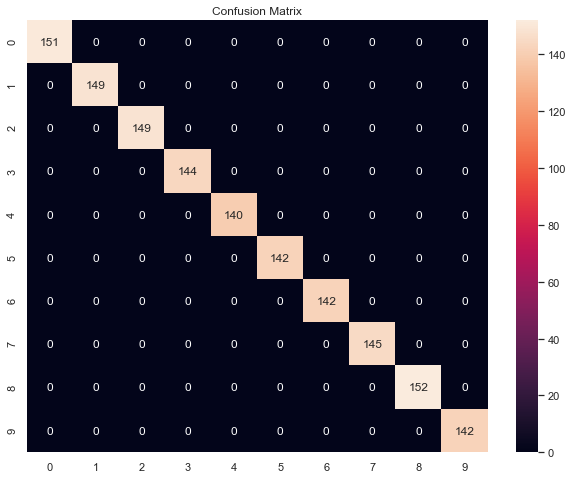

====================== Validation set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00        10
     Digit 1       1.00      1.00      1.00        22
     Digit 2       1.00      1.00      1.00        11
     Digit 3       1.00      0.95      0.98        22
     Digit 4       1.00      1.00      1.00        16
     Digit 5       1.00      0.94      0.97        18
     Digit 6       0.95      1.00      0.98        20
     Digit 7       1.00      1.00      1.00        15
     Digit 8       0.93      1.00      0.97        14
     Digit 9       1.00      1.00      1.00        13

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



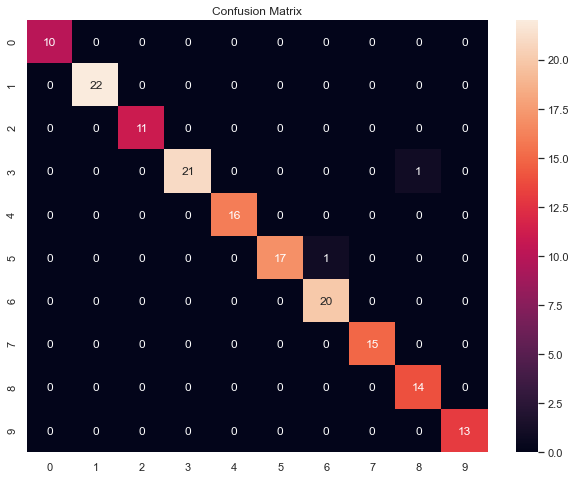

In [26]:
folds = [[train_index, validation_index] for train_index, validation_index in kfold.split(X_train)]
tidx, vidx = folds[best_fold_mlp]

get_metrics(best_mlp, X_train[tidx], y_train[tidx], X_train[vidx], y_train[vidx])

MLP managed to perform a perfect classification of the digits in the training set, while in the validation set, only 2 digits were classified incorrectly. The result is very satisfactory and indicates that the algorithm has learned to generalize well what was learned in training.

### Random Forest

====================== Training set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00       138
     Digit 1       1.00      1.00      1.00       150
     Digit 2       1.00      1.00      1.00       143
     Digit 3       1.00      1.00      1.00       149
     Digit 4       1.00      1.00      1.00       136
     Digit 5       1.00      1.00      1.00       147
     Digit 6       1.00      1.00      1.00       146
     Digit 7       1.00      1.00      1.00       146
     Digit 8       1.00      1.00      1.00       158
     Digit 9       1.00      1.00      1.00       142

    accuracy                           1.00      1455
   macro avg       1.00      1.00      1.00      1455
weighted avg       1.00      1.00      1.00      1455



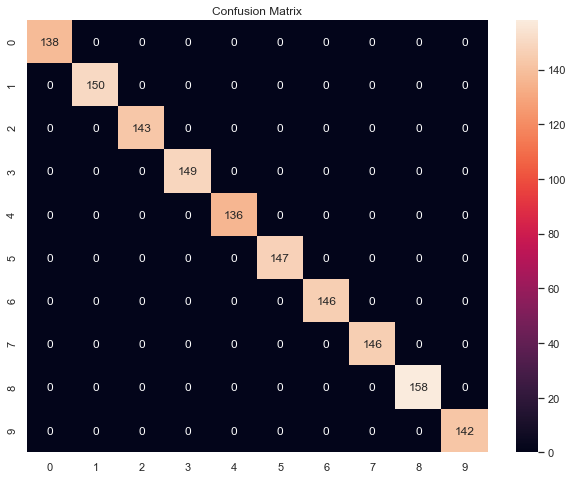

====================== Validation set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00        23
     Digit 1       1.00      1.00      1.00        21
     Digit 2       1.00      1.00      1.00        17
     Digit 3       1.00      1.00      1.00        17
     Digit 4       1.00      1.00      1.00        20
     Digit 5       0.93      1.00      0.96        13
     Digit 6       1.00      1.00      1.00        16
     Digit 7       1.00      1.00      1.00        14
     Digit 8       0.89      1.00      0.94         8
     Digit 9       1.00      0.85      0.92        13

    accuracy                           0.99       162
   macro avg       0.98      0.98      0.98       162
weighted avg       0.99      0.99      0.99       162



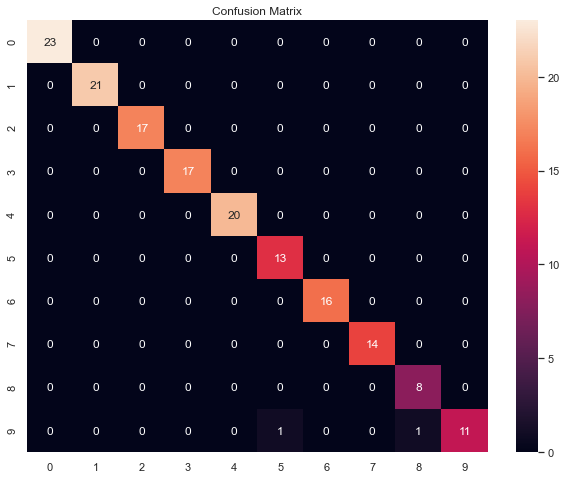

In [27]:
tidx, vidx = folds[best_fold_rf]
get_metrics(best_rf, X_train[tidx], y_train[tidx], X_train[vidx], y_train[vidx])

Random Forest, like MLP, managed to perform a perfect classification of the digits in the training set, while in the validation set, only 2 digits were classified incorrectly. The result is very satisfactory and indicates that the algorithm has learned to generalize well what was learned in training.

## Metrics from Test set

Finally, given that the algorithms performed well in both the training and validation sets, the following lines are used to evaluate the models in the test set, to confirm the generalizability of the algorithms.

### Multi-layer Perceptron algorithm (MLP)

====================== Test set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00        17
     Digit 1       1.00      1.00      1.00        11
     Digit 2       1.00      1.00      1.00        17
     Digit 3       1.00      0.94      0.97        17
     Digit 4       1.00      1.00      1.00        25
     Digit 5       0.96      1.00      0.98        22
     Digit 6       1.00      1.00      1.00        19
     Digit 7       1.00      0.95      0.97        19
     Digit 8       0.89      1.00      0.94         8
     Digit 9       0.96      0.96      0.96        25

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



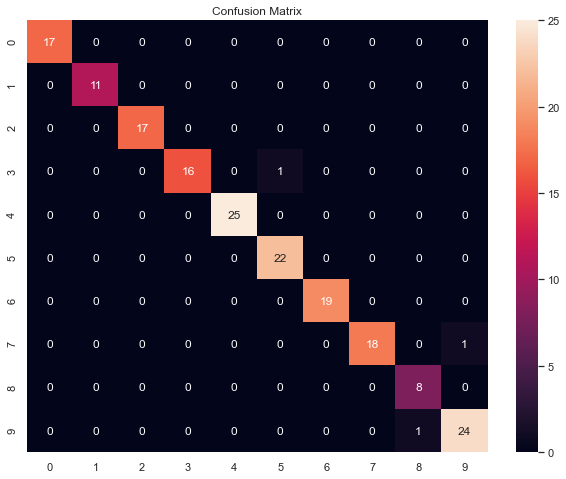

In [28]:
pred_test_mlp = best_mlp.predict(X_test)
get_metrics_split(y_test, pred_test_mlp, split="Test", verbose=True)

### Random Forest

====================== Test set ======================
              precision    recall  f1-score   support

     Digit 0       1.00      0.94      0.97        17
     Digit 1       1.00      1.00      1.00        11
     Digit 2       1.00      1.00      1.00        17
     Digit 3       1.00      0.94      0.97        17
     Digit 4       0.96      1.00      0.98        25
     Digit 5       1.00      1.00      1.00        22
     Digit 6       1.00      1.00      1.00        19
     Digit 7       0.90      0.95      0.92        19
     Digit 8       0.89      1.00      0.94         8
     Digit 9       0.96      0.92      0.94        25

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



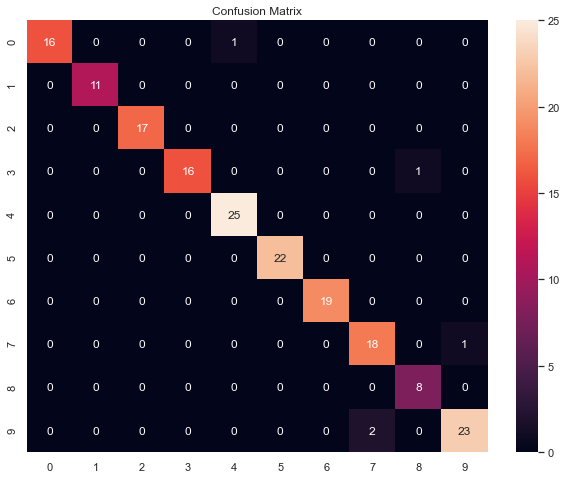

In [29]:
pred_test_rf = best_rf.predict(X_test)
get_metrics_split(y_test, pred_test_rf, split="Test", verbose=True)

As expected, both algorithms maintained the good results previously presented, with MLP classifying only 3 images incorrectly, and Random forest classifying 5 images incorrectly. However, instead of what was expected for the visualization of the data using t-SNE, the digits with the biggest error in the classification were not 9 and 1.

Although the results are already very good, it should be possible to improve them even more, using other algorithms such as a Convolutional Neural Network, and continuing to optimize the parameters of the algorithms used, using a grid-search for example.